# cNMF in `cellarium-ml`

Yang Xu

Stephen Fleming

2024.11.20

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond. This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF). The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

__Pre-processing__ which can also be done using `cellarium-ml` but is not part of this notebook.

0. Compute highly-variable genes.

__Running cNMF happens in four stages:__

1. The initial fit on selected highly-variable genes.

    This amounts to creating a YAML file and then running a single command from the command line:
    ```bash
    cellarium-ml nmf fit --config config.yaml
    ```

2. Interactive plotting in the notebook to help determine optimal `k`, `density_threshold`, and `local_neighborhood_size`.

    Uses functions that are currently called `update_consensusD()` and `calculate_rec_error()` in this notebook, along with some plotting.

3. Computing per-cell factor loadings.

    Uses the function currently called `get_embedding()` in this notebook.

4. Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

    After running get_embedding(), gene loading for full transcriptome would be updated as the same time per-cell factor loadings were calculated.

NOTE: You will need to use the `cnmf-yx-streamline` branch of `cellarium-ml` on github.

In [1]:
from cellarium.ml.core import CellariumPipeline, CellariumModule
from cellarium.ml.utilities.data import AnnDataField, densify
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)
from cellarium.ml.models.nmf import get_embedding, compute_consensus_factors, calculate_rec_error

import os
from string import Template

import torch
import numpy as np
import pandas as pd

import scipy
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, vector_friendly=True)

## Parameters

In [3]:
# choose which values of k to use

# for experiment, only run k as 10, 11, and 12
k_values: list[int] = list(range(18,19))  # this thing needs to be a python list

# choose how many repeats of NMF to run to create a "consensus"
num_repeats: int = 200 # 100 # 

## Data

This demo uses a human heart dataset which is hosted in a google bucket. We will first download the dataset to the machine where this notebook is running, and then we will run cNMF.

We require 2 files:

- The dataset in h5ad format. In this case the entire dataset is a single h5ad file, but `cellarium-ml` can use an arbitrary number of h5ad files.
- The highly variable genes in CSV format.

In [4]:
# change these values to run on a different dataset:

# define file paths

dataset_h5ad = "gs://yx-data/BA46_n180_astrocyte_filtered.h5ad" # "gs://yx-data/simulated_nmf_data_multinom_10%.h5ad"

highly_variable_genes_csv = "gs://yx-data/BA46_n180_Astrocytes.hvg_list.txt" # "gs://yx-data/simulated_nmf_P05_hvg.csv"

working_dir = "./tmp"

In [5]:
!mkdir -p $working_dir

In [6]:
# localize data

local_h5ad = os.path.join(working_dir, "data.h5ad")
local_hvg_csv = os.path.join(working_dir, "hvg.csv")

# !gsutil cp $dataset_h5ad $local_h5ad
# !gsutil cp $highly_variable_genes_csv $local_hvg_csv

## Config file

This part contains a hack to make things seem simpler: we provide a template config.yaml file here and we modify that file according to the inputs above.

In reality, you would probably create the config.yaml file directly without using the little helpers in this section of the notebook. But this helper makes things smoother for this demo.

In [7]:
# define the path to the config file
config_file_template = "../examples/cli_workflow/nmf_config_template.yaml"  # path of the config template file needs to be specified here

In [8]:
adata = sc.read_h5ad(local_h5ad)
dataset_ncells = adata.n_obs
n_genes_total = adata.n_vars

In [9]:
# modification of the yaml config file to point to this data

local_config_yaml = os.path.join(working_dir, "config.yaml")

with open(config_file_template, "r") as file:
    yaml_text = file.read()

substitutions = {
    "highly_variable_genes_csv": os.path.abspath(local_hvg_csv),
    "dataset_h5ad": os.path.abspath(local_h5ad),
    "dataset_ncells": dataset_ncells,
    "k_values": k_values,
    "num_repeats": num_repeats,
    "n_genes_total": n_genes_total,
    # "transformed_data_mean": transformed_data_mean,
}

template = Template(yaml_text)
customized_yaml = template.substitute(substitutions)

# write the customized YAML to a local file in the working directory
with open(local_config_yaml, "w") as file:
    file.write(customized_yaml)

print(f"Config YAML written to: {local_config_yaml}")

Config YAML written to: ./tmp/config.yaml


In [10]:
# take a look at the config file we end up with: again you could skip the above and write this file manually

!cat $local_config_yaml

# lightning.pytorch==2.4.0
seed_everything: true
trainer:
  num_nodes: 1
  max_epochs: 20
model:
  cpu_transforms:
  - class_path: cellarium.ml.transforms.Filter
    init_args:
      filter_list:
        !FileLoader
        file_path: /home/jupyter/cellarium-ml/notebooks/tmp/hvg.csv
        loader_fn: pandas.read_csv
        attr: "ensembl_id"
        convert_fn: pandas.Series.to_list
  transforms: null
  model:
    class_path: cellarium.ml.models.NonNegativeMatrixFactorization
    init_args:
      var_names_g: null
      var_names_hvg:
        !FileLoader
        file_path: /home/jupyter/cellarium-ml/notebooks/tmp/hvg.csv
        loader_fn: pandas.read_csv
        attr: "ensembl_id"
        convert_fn: pandas.Series.to_list
      k_values: [18]
      r: 200
      full_g: 34456
      log_variational: false
      algorithm: mairal
  is_initialized: false
data:
  dadc:
    class_path: cellarium.ml.data.DistributedAnnDataCollection
    init_args:
      filenames: /home/jupyter/cellarium-m

## Run cNMF

In [10]:
!cellarium-ml nmf fit -c $local_config_yaml

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | pipeline | CellariumPipeline | 1     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
Epoch 19: 100%|████████████████████████| 63/63 [00:21<00:00,  2.90it/s, v_num=2]


## Load the trained NMF model

and the dataset

In [11]:
# helper function

def get_pretrained_model_as_pipeline(
    trained_model: str = "../", 
    transforms: list[torch.nn.Module] = [],
) -> CellariumPipeline:

    model = CellariumModule.load_from_checkpoint(trained_model).model
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # insert the trained model params
    model.to(device)
    model.eval()

    # construct the pipeline
    pipeline = CellariumPipeline(transforms + [model])

    return pipeline

def get_cellarium_dataset_from_h5ad(
    h5ad: str, 
    batch_size: int = 1024, 
    shard_size: int | None = None, 
    shuffle: bool = False, 
    drop_last_indices: bool = False,
) -> IterableDistributedAnnDataCollectionDataset:
    """
    Get IterableDistributedAnnDataCollectionDataset from an h5ad file specifier.

    Args:
        h5ad: h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        drop_last_indices: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """
    dadc = DistributedAnnDataCollection(
        h5ad,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
            "obs_names_n": AnnDataField(attr="obs_names"),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last_indices=drop_last_indices,
    )
    return dataset

In [12]:
# load trained module

ckpt_file = os.getcwd()+"/NMF.ckpt"  # currently this is hard-coded, but we will change this
pipeline = get_pretrained_model_as_pipeline(
    trained_model=ckpt_file,
)

In [13]:
# get a dataset object in the necessary cellarium-ml format

dataset = get_cellarium_dataset_from_h5ad(
    os.path.abspath(local_h5ad), 
    shard_size=adata.n_obs,
    shuffle=False, 
    drop_last_indices=False,
)
dataset

### Compute consensus factors

as well as "stability" scores, a.k.a. silhouette scores

In [14]:
# calculate consensus D for all Ks

# change these thresholds if desired
density_threshold = 0.1 # 
local_neighborhood_size = 0.1 # 

consensus_stat = compute_consensus_factors(
    pipeline[-1],
    density_threshold=density_threshold, 
    local_neighborhood_size=local_neighborhood_size,
)

silhouette score of k=18: 0.9699


### Create clustermap plots

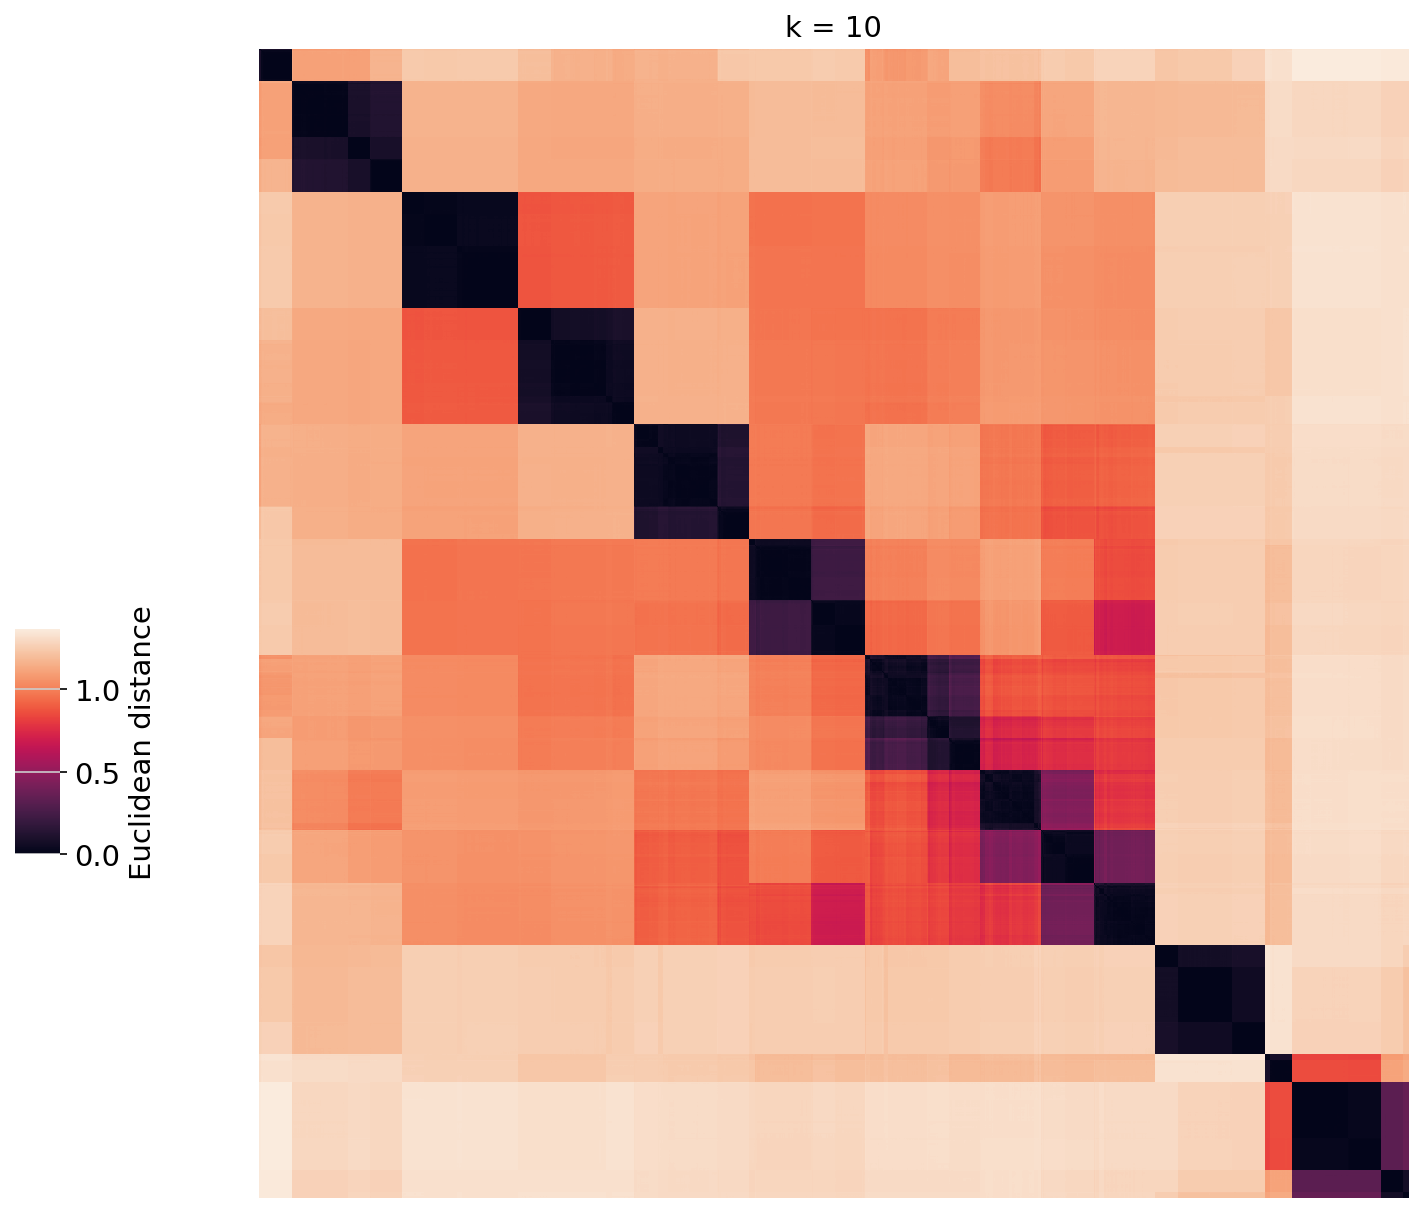

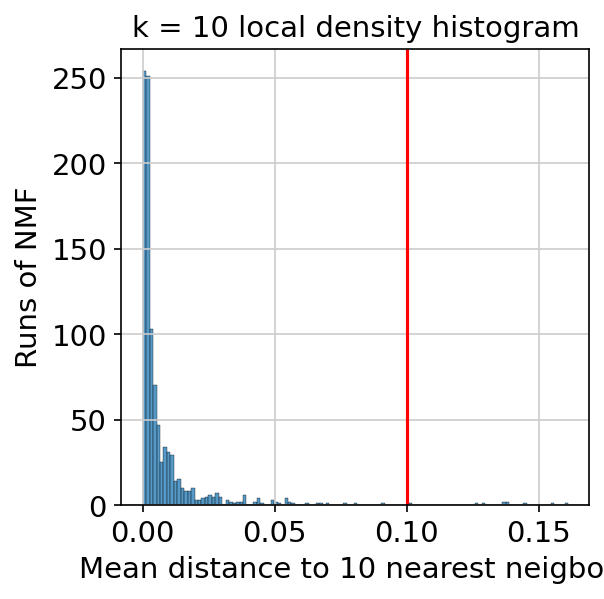

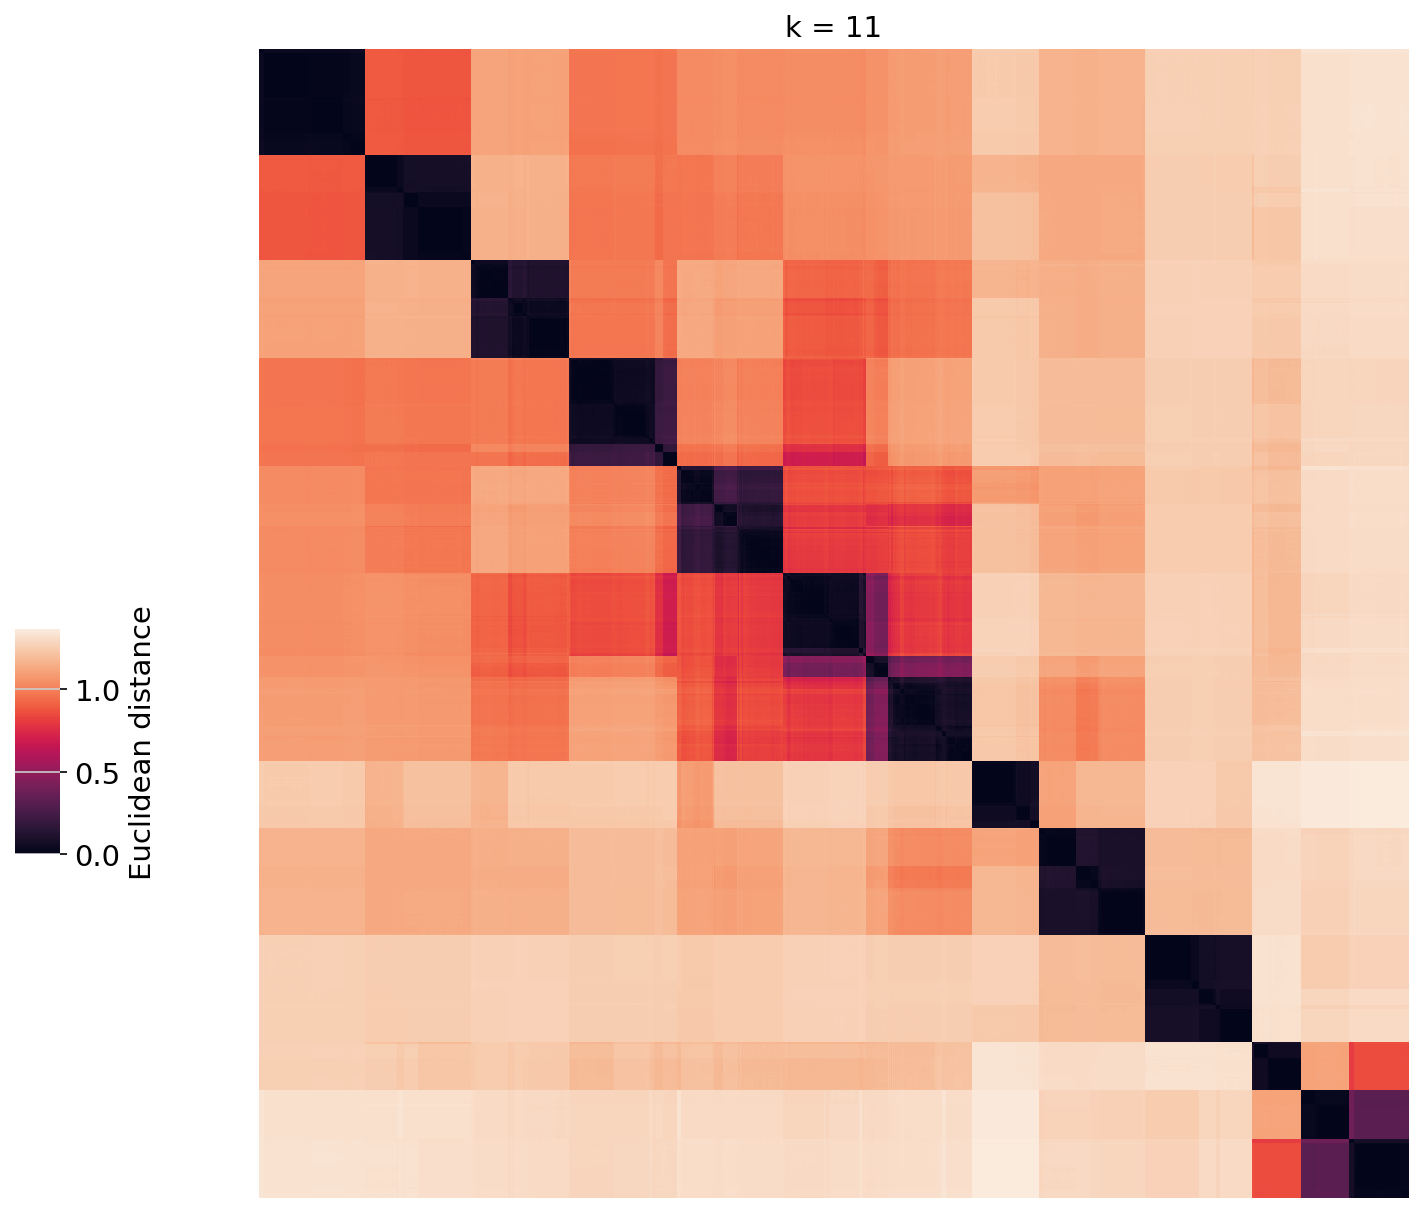

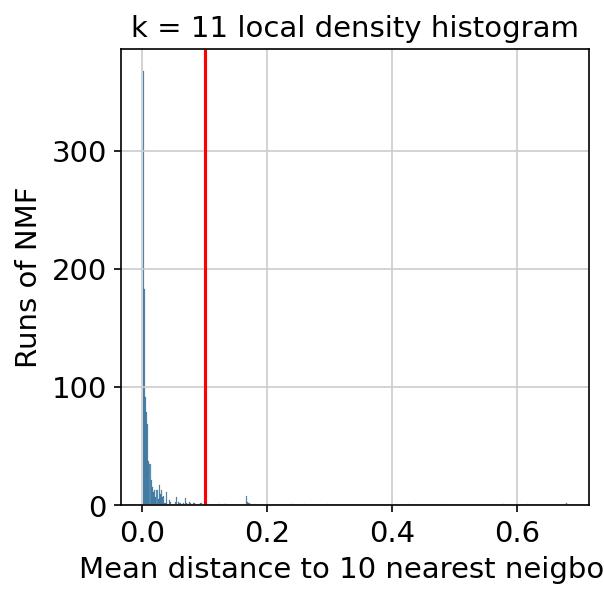

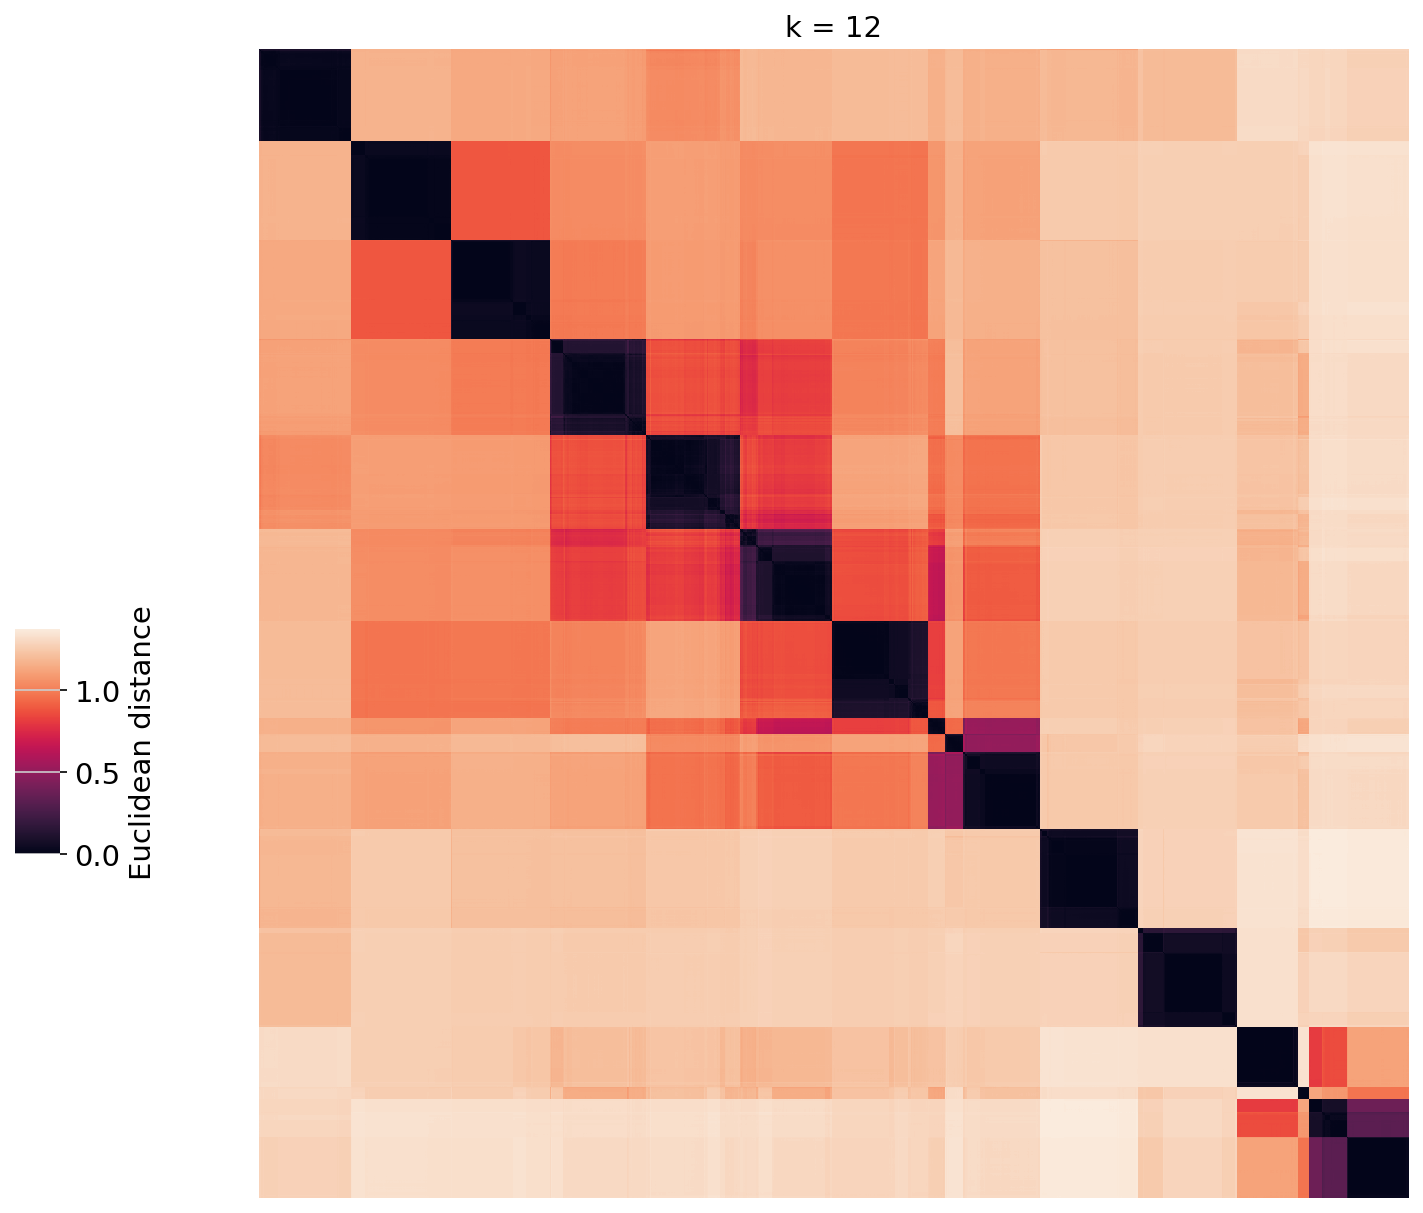

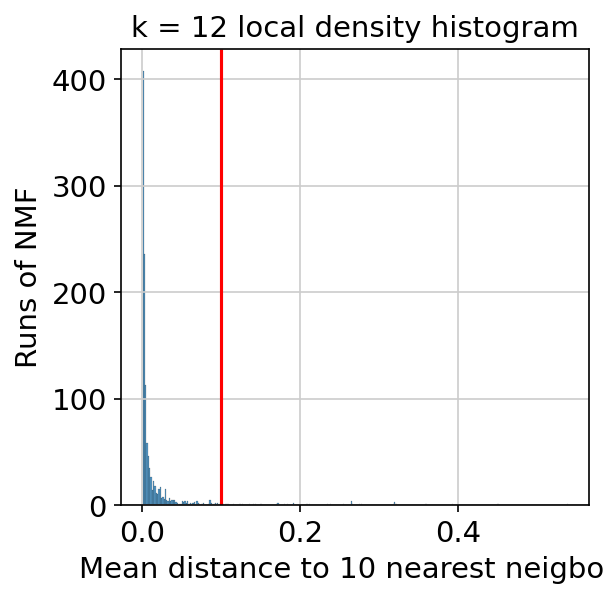

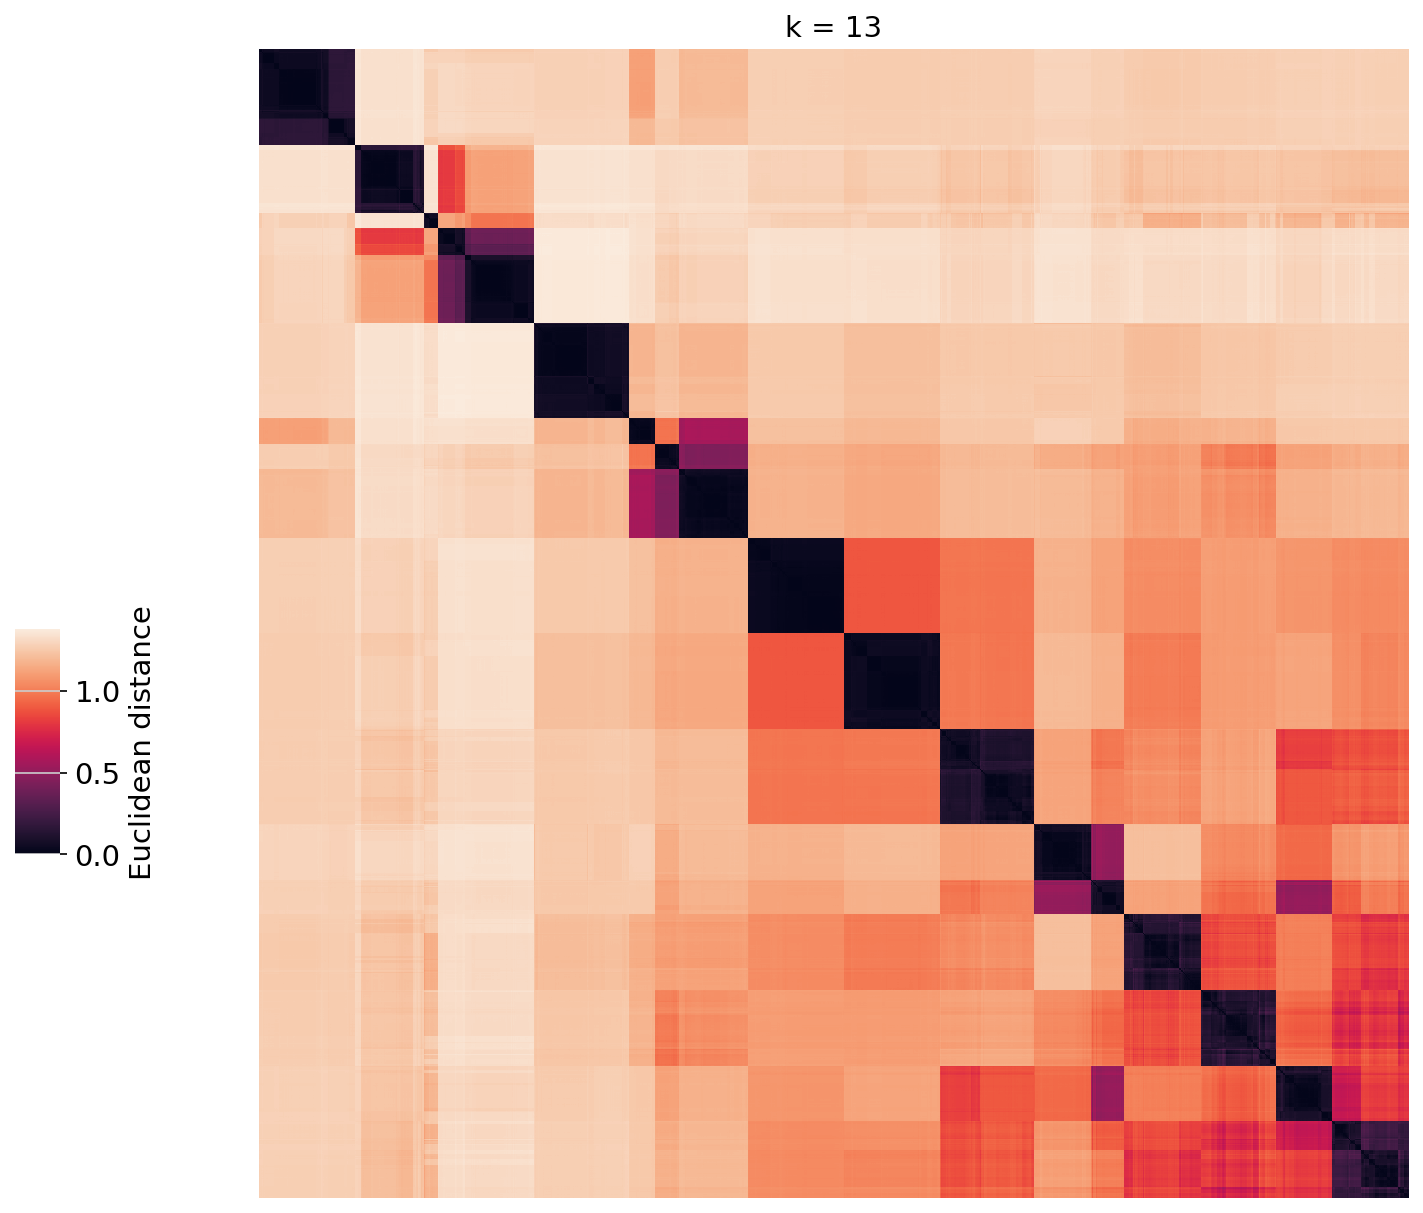

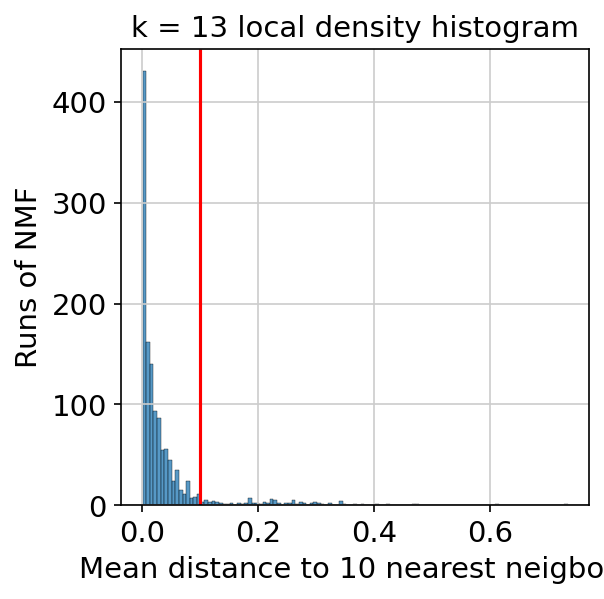

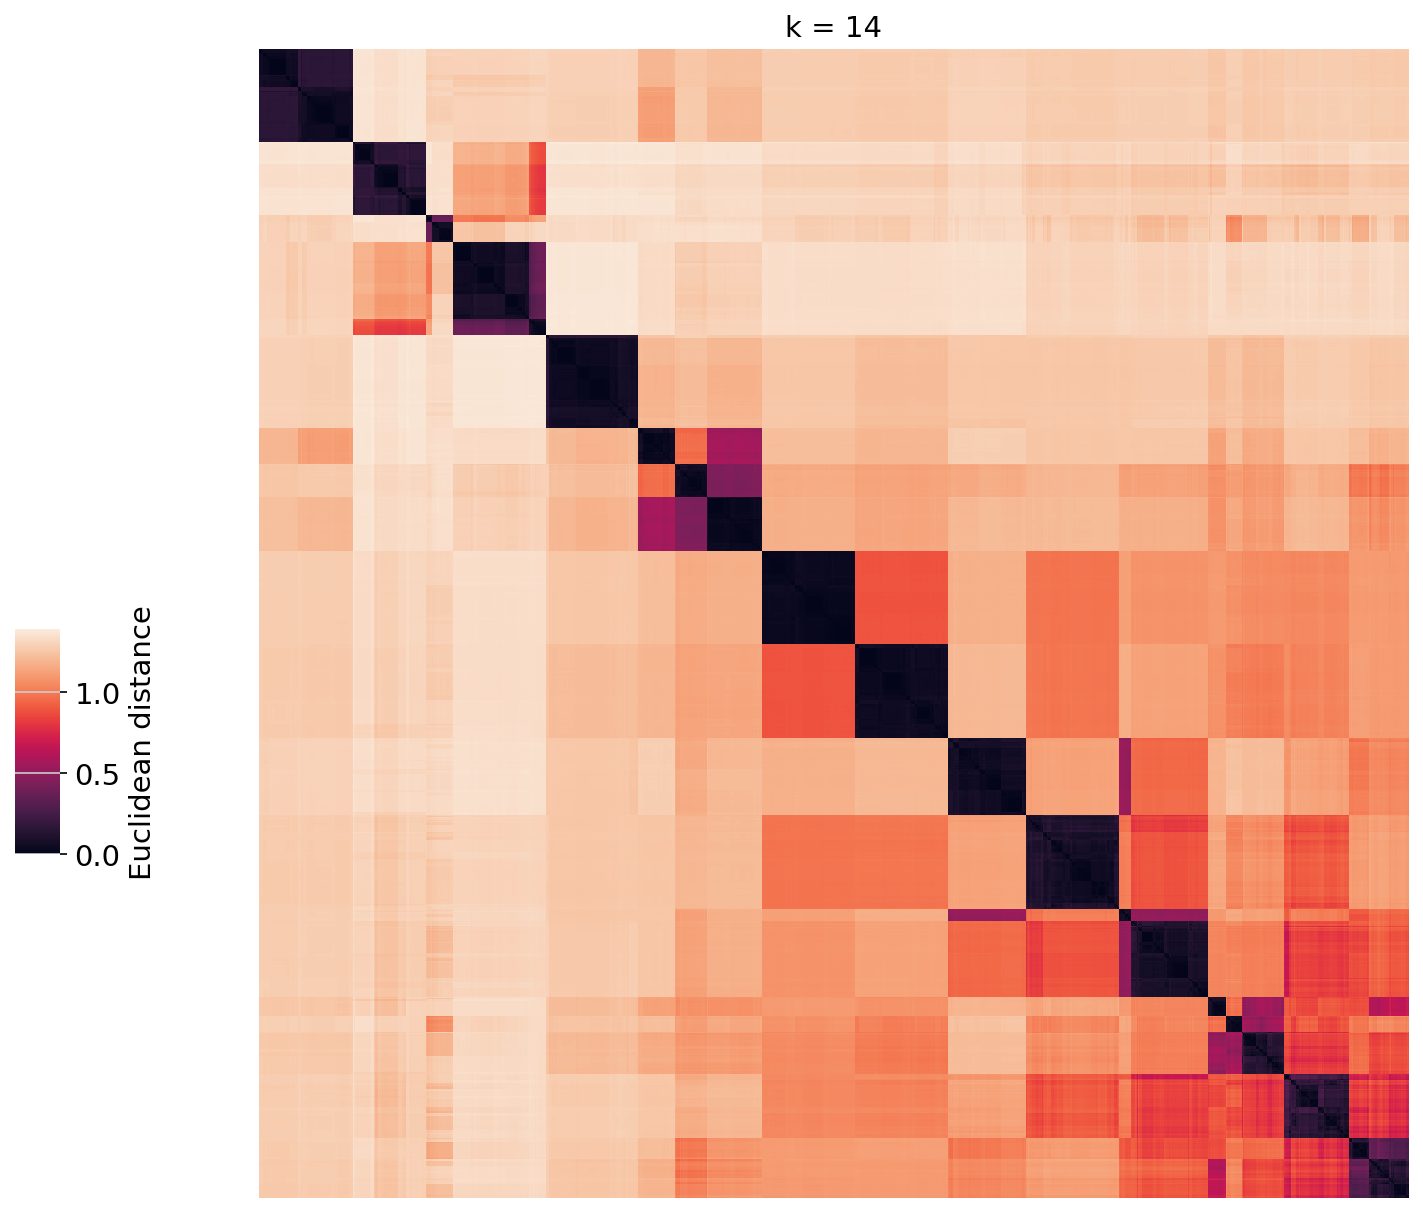

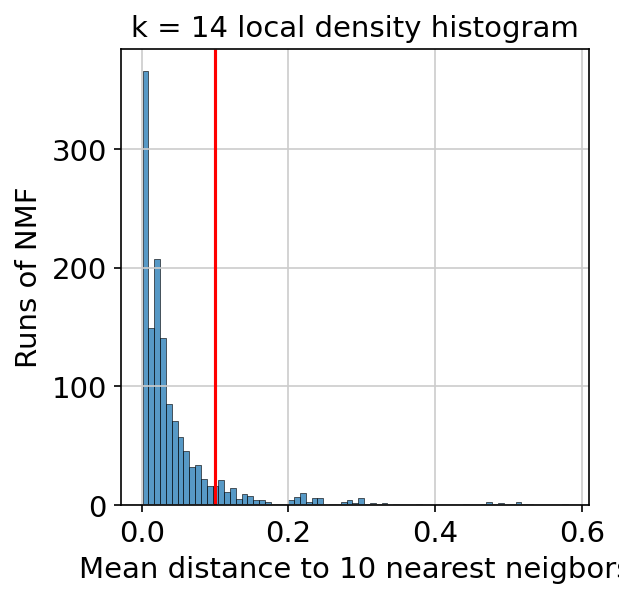

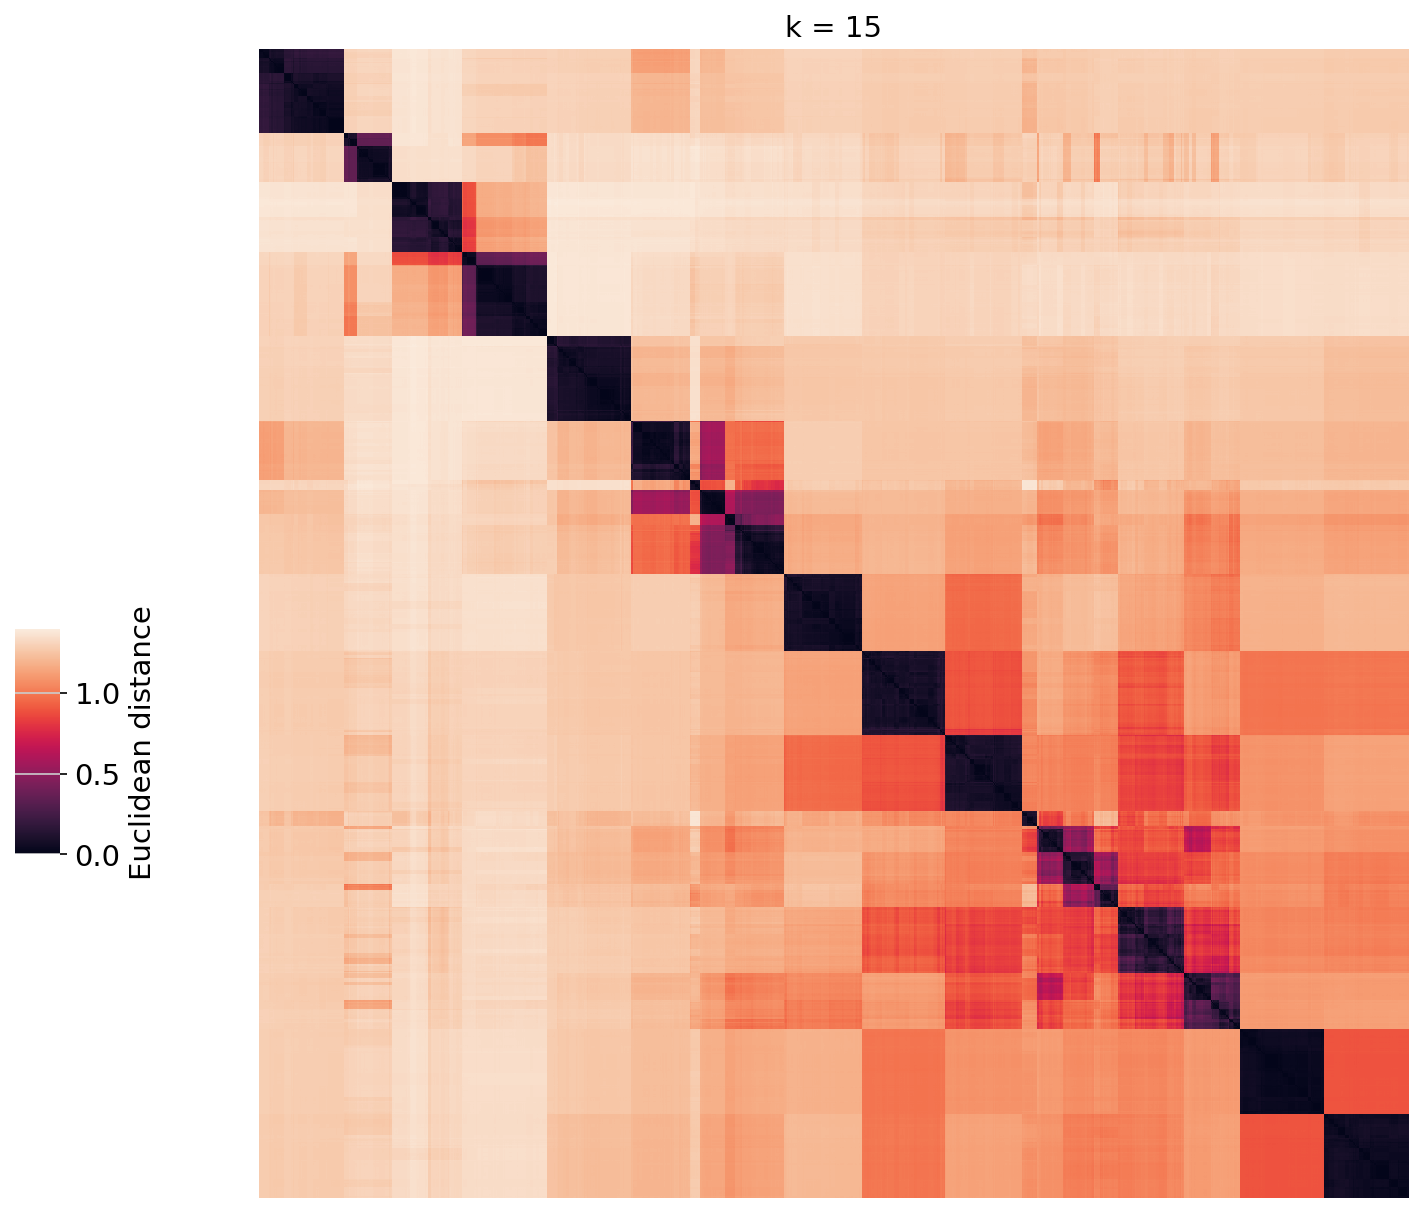

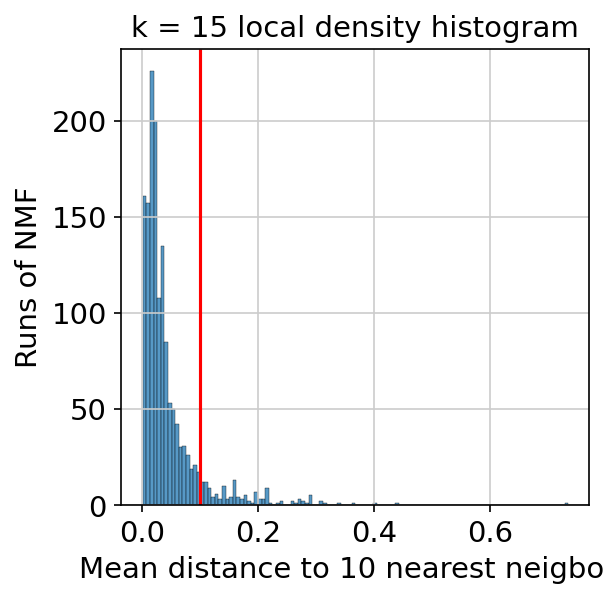

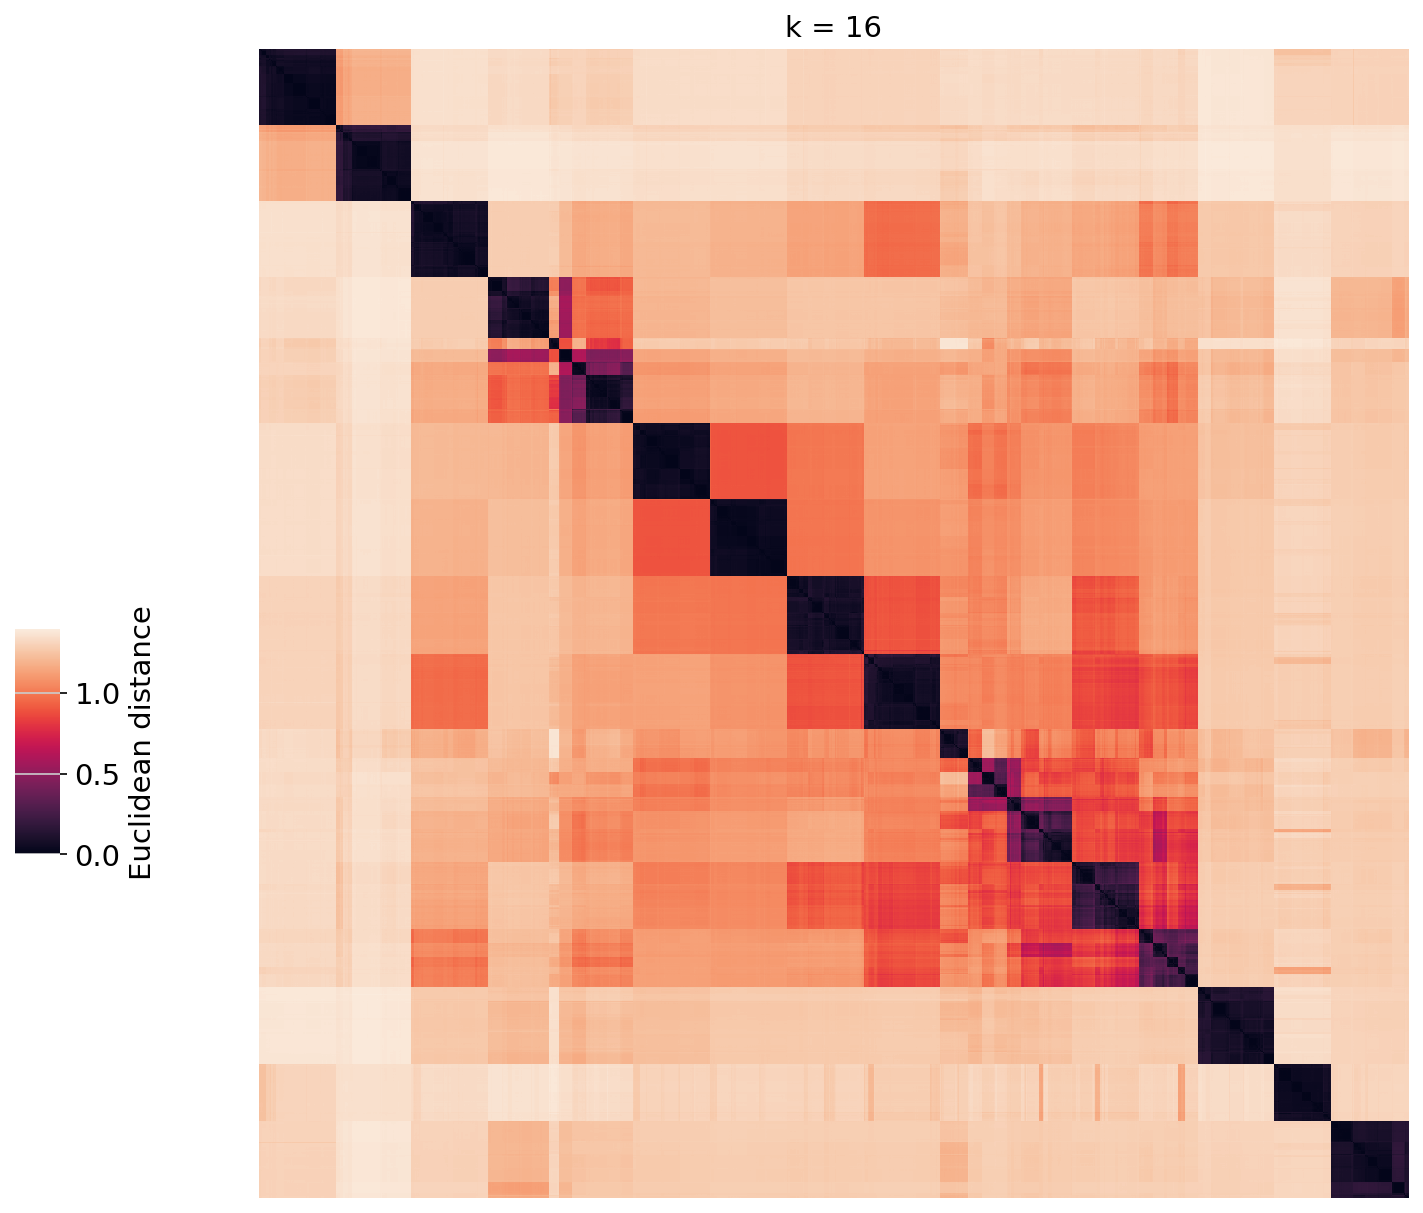

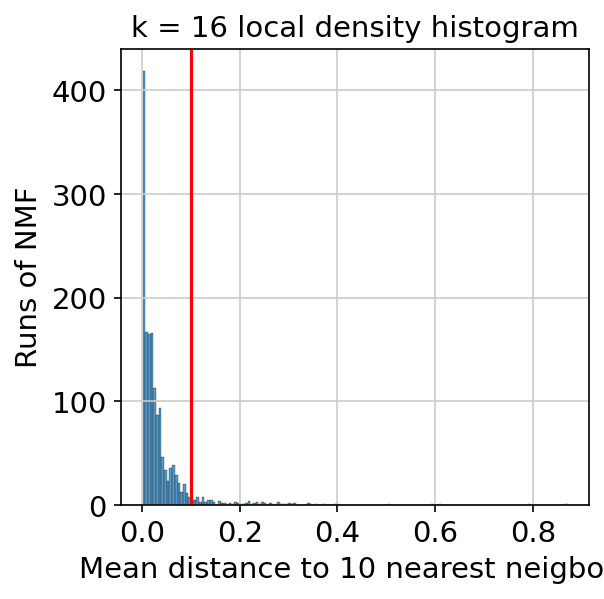

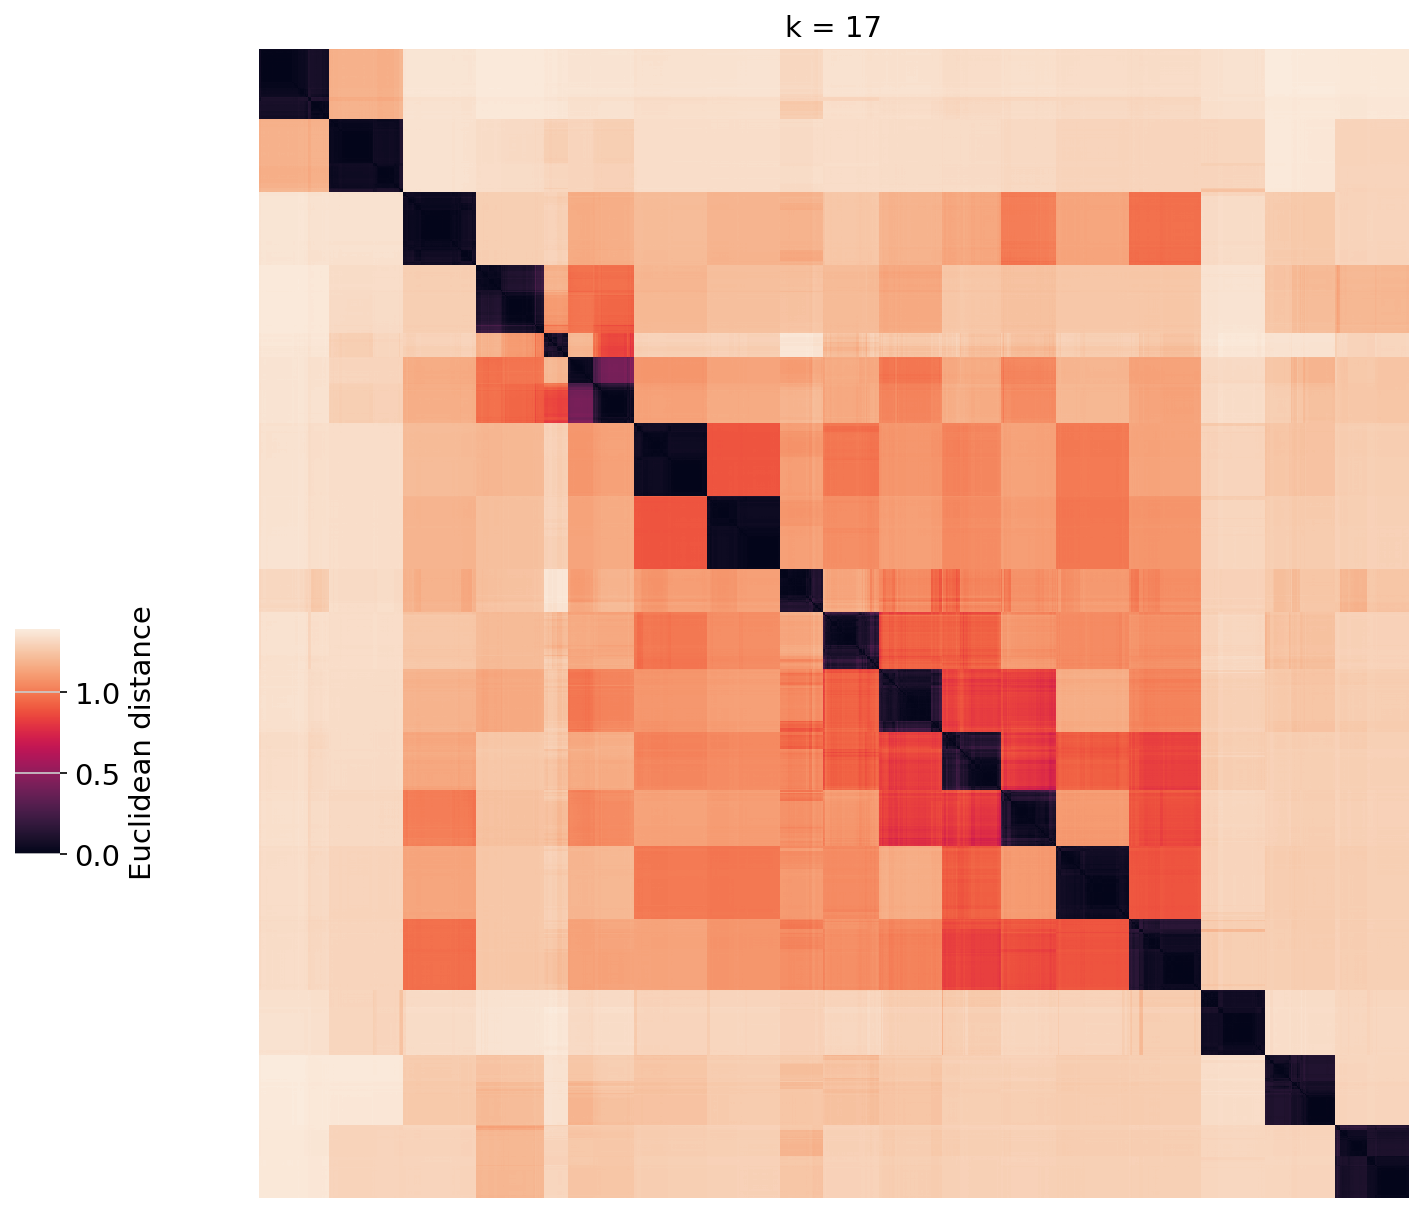

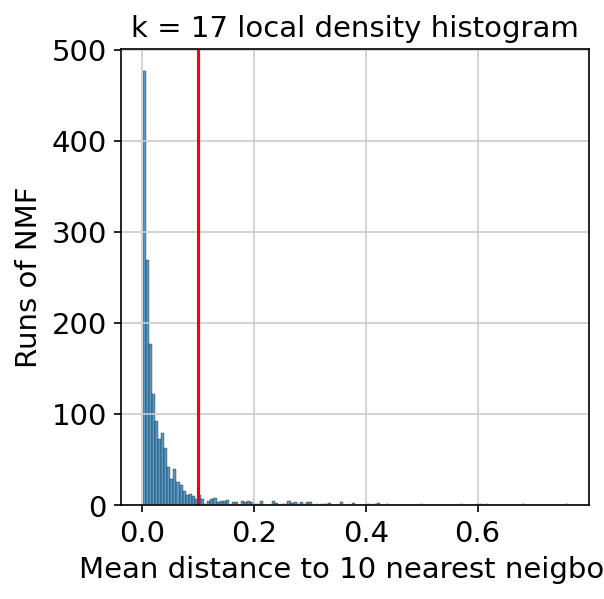

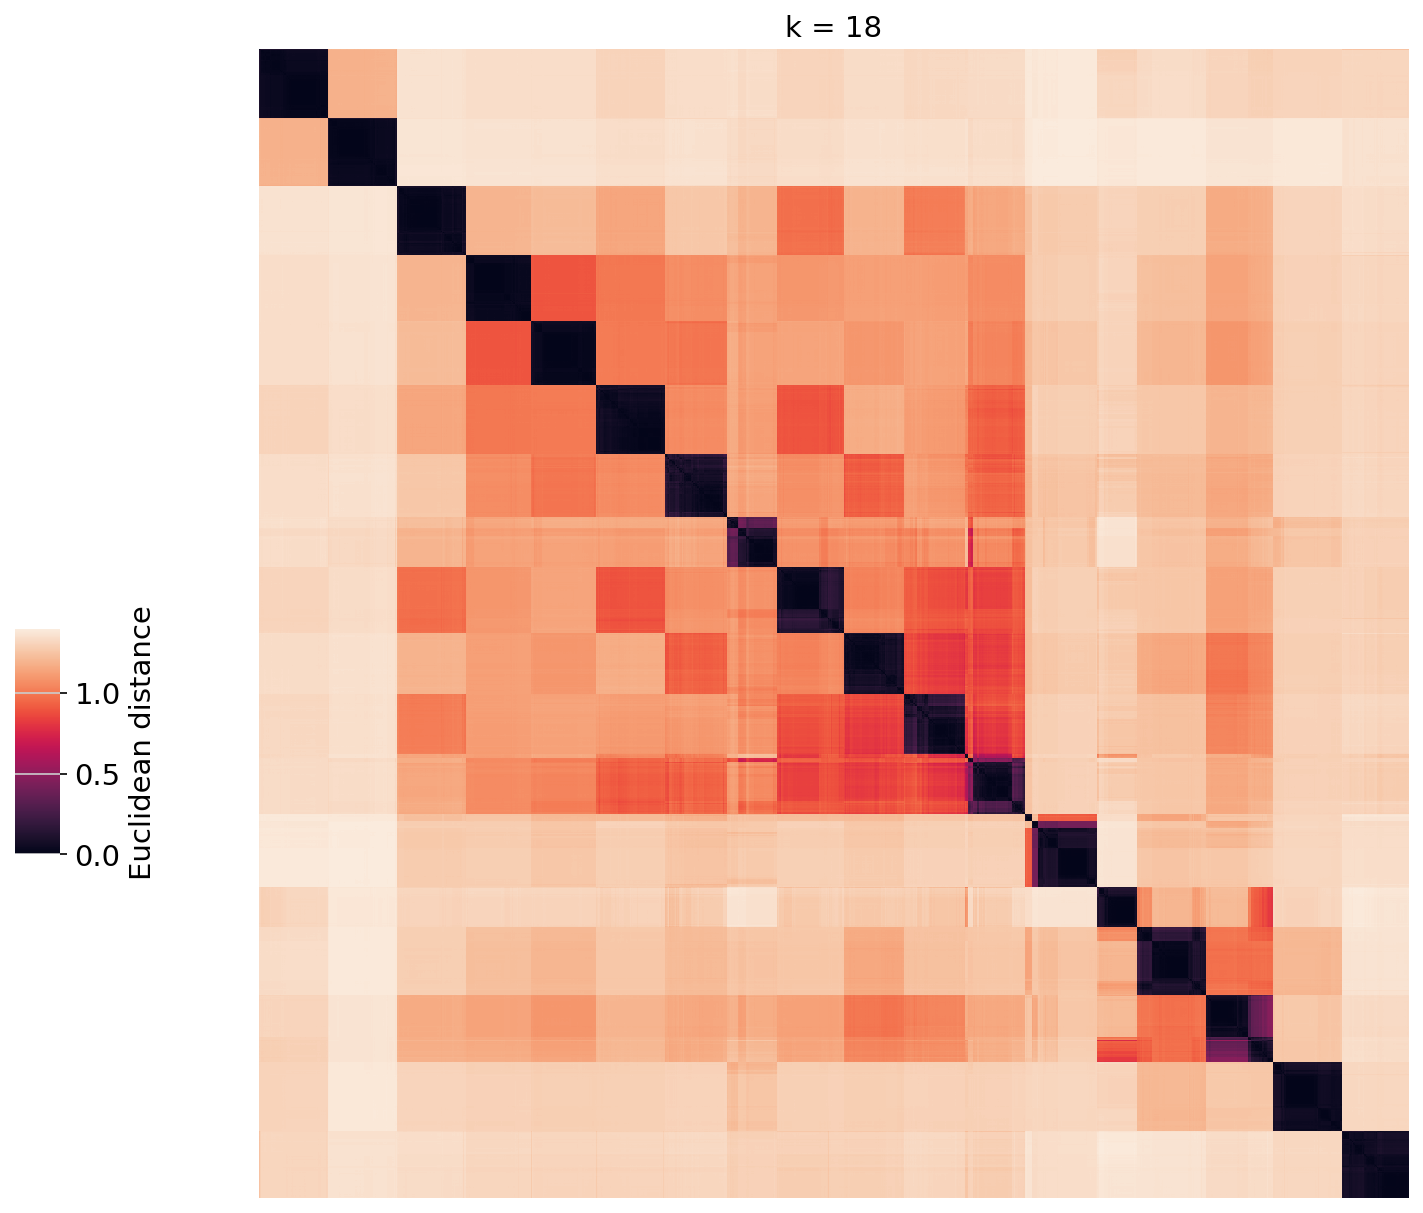

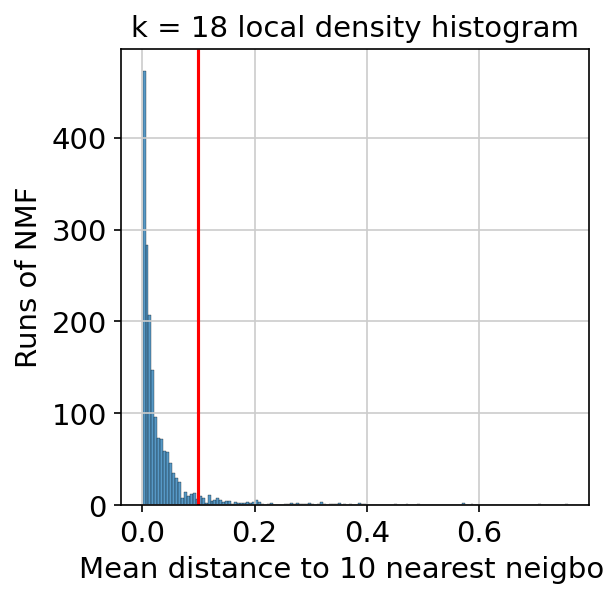

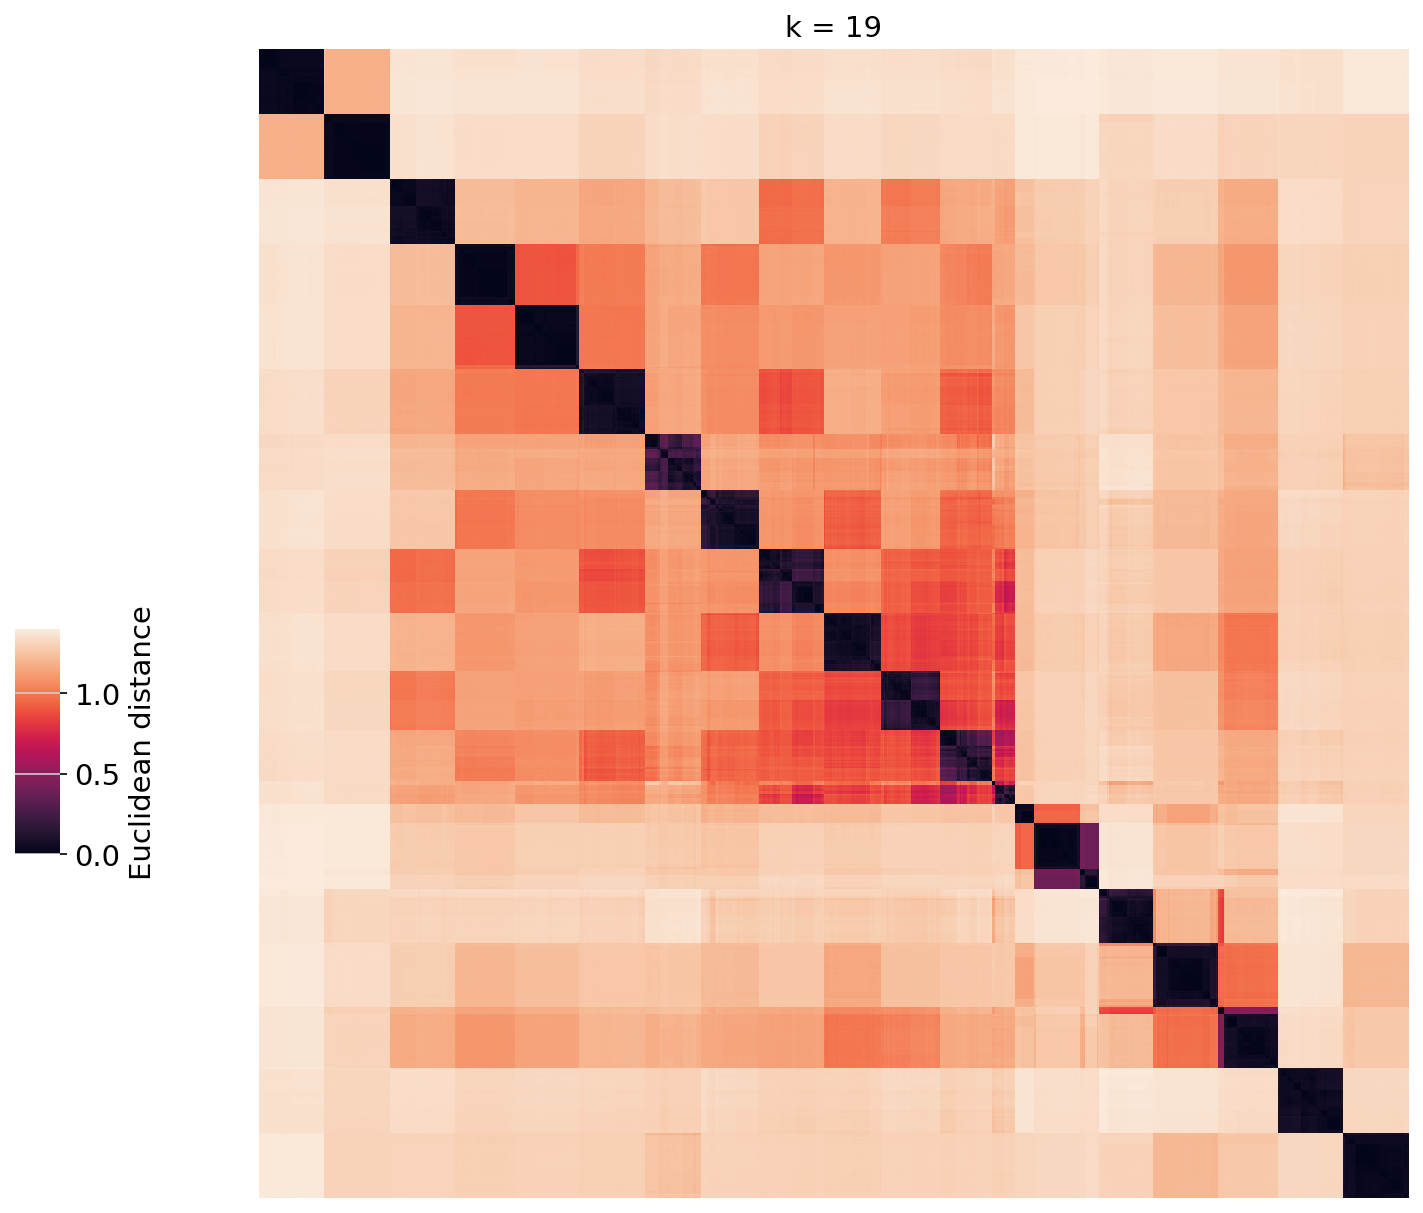

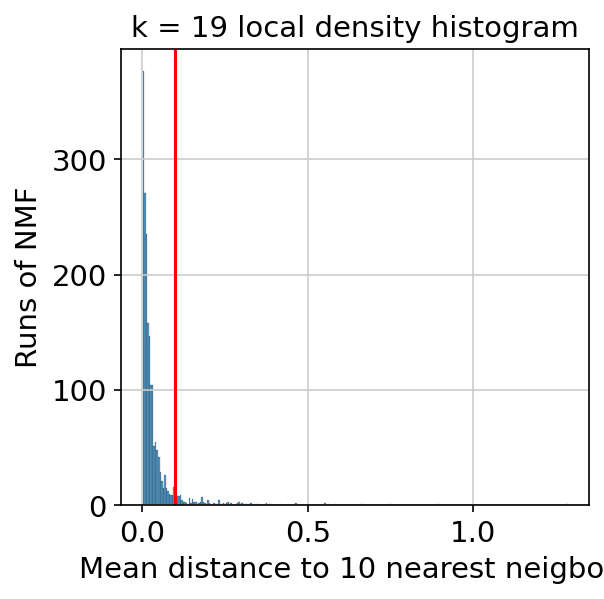

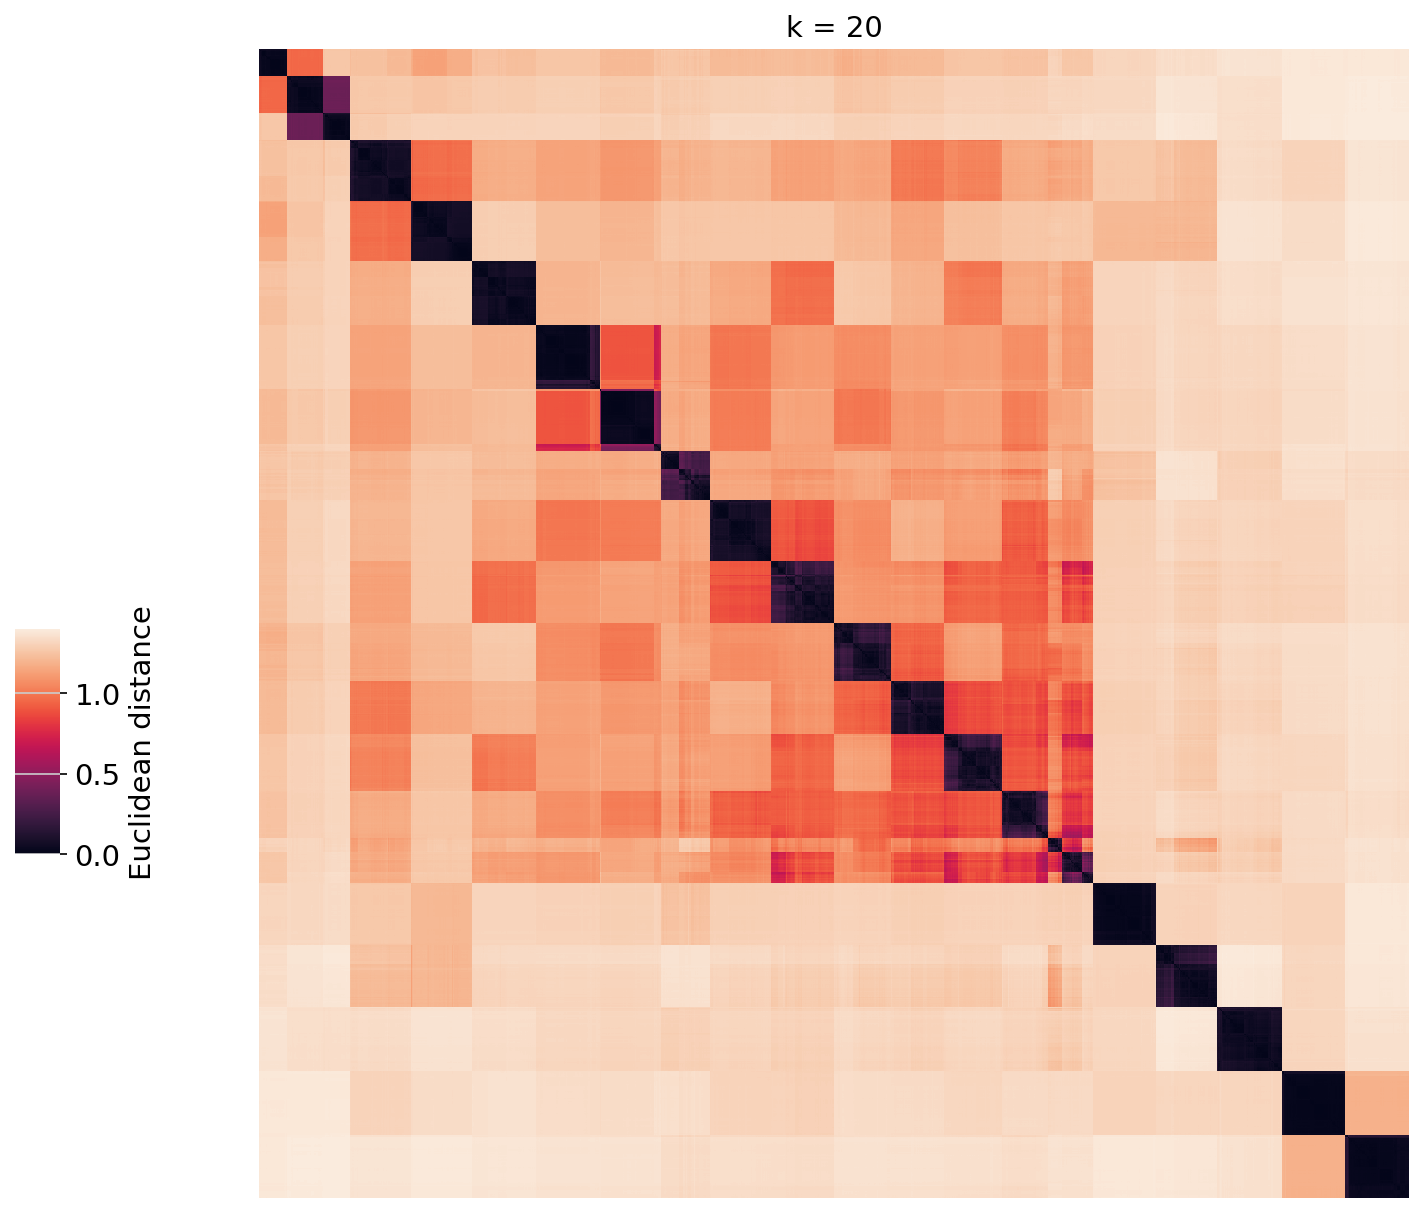

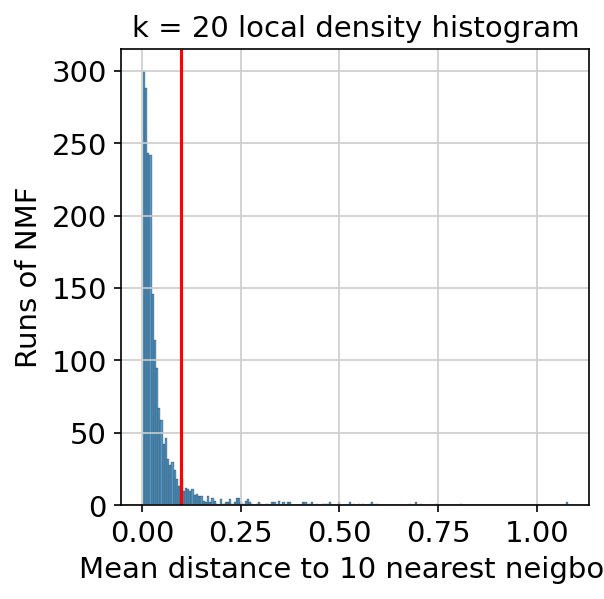

In [21]:
for k in k_values:
    cg = sns.clustermap(consensus_stat[k]['topk_euc_dist'].cpu().numpy(), 
                   row_cluster=True, col_cluster=True, cbar_pos=(0.05, 0.25, 0.03, 0.15),
                   xticklabels=False, yticklabels=False, rasterized=True)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    # cg.cax.set_visible(False)
    cg.cax.set_ylabel('Euclidean distance')
    cg.ax_heatmap.set_title(f"k = {k}")
    plt.show()
    
    sns.histplot(consensus_stat[k]['local_neigh_dist'].cpu().numpy())
    ymax = plt.gca().get_ylim()[1]
    plt.vlines(density_threshold, ymin=0, ymax=ymax, color='Red')
    plt.xlabel(f'Mean distance to {int(num_repeats * local_neighborhood_size)} nearest neigbors')
    plt.ylabel('Runs of NMF')
    plt.title(f"k = {k} local density histogram")
    plt.ylim(0, ymax)
    
    plt.show()

### Compute reconstruction error at each k

In [24]:
# we need to calculate the reconstruction error: this takes time
rec_errors = calculate_rec_error(dataset, pipeline)

100%|██████████| 63/63 [00:37<00:00,  1.69it/s]


### Create the k-selection plot

In [25]:
silhouette_scores = {}
for k in k_values:
    silhouette_scores[k] = consensus_stat[k]['stability']
eval_metrics = pd.DataFrame.from_dict(silhouette_scores, orient='index')
eval_metrics.columns = ['stability']
eval_metrics['rec_error'] = rec_errors

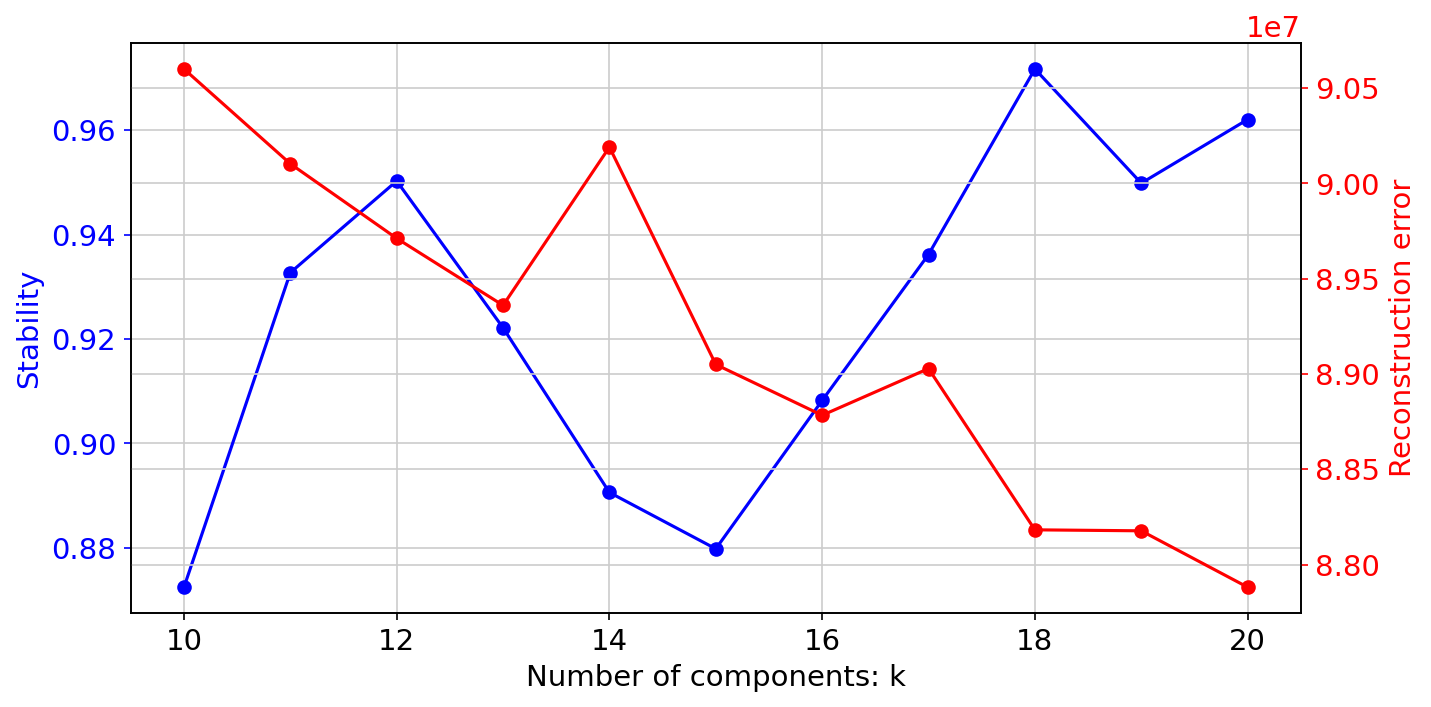

In [26]:
# plot stability and reconstruction error

plt.figure(figsize=(10, 5))
plt.plot(eval_metrics.index, eval_metrics['stability'], 'o-', color='b')
plt.grid(True)
plt.ylabel('Stability', color='b')
plt.xlabel('Number of components: k')
plt.gca().tick_params(axis='y', colors='b')
plt.twinx()
plt.plot(eval_metrics.index, eval_metrics['rec_error'], 'o-', color='r')
plt.ylabel('Reconstruction error', color='r')
plt.gca().tick_params(axis='y', colors='r')
plt.show()

### Compute per-cell loadings

The loadings of each factor, computed for each cell.

In [15]:
best_k = 18
obsm_key_added = 'X_nmf'

In [16]:
# get per-cell factor loadings using the best k: this takes time

pipeline[-1].log_variational = False

# set if_get_final_gene_loading as True to get gene loading for full transcriptome
df = get_embedding(dataset, pipeline, k=best_k, if_get_final_gene_loading=True)

100%|██████████| 63/63 [01:02<00:00,  1.01it/s]


In [17]:
# add this information to the anndata object

adata.obsm['X_nmf'] = df.loc[adata.obs_names].values
adata.obsm['X_nmf'].shape

(64483, 18)

In [18]:
# see whether the loadings sum to 1 (nearly)

adata.obsm['X_nmf'].sum(axis=1)

array([1976.6382  , 1935.7052  , 1640.2493  , ...,   17.156166,
         21.126097,   16.263296], dtype=float32)

In [20]:
df = pd.DataFrame(adata.obsm['X_nmf'])

In [21]:
full_D_kg = getattr(pipeline[-1], f"full_D_{best_k}_kg")
full_D_kg = full_D_kg.cpu().numpy()

full_D_kg = pd.DataFrame(full_D_kg)
full_D_kg.columns = adata.var.index
full_D_kg = full_D_kg.T

In [22]:
gene_factor = pd.read_csv('/home/jupyter/data/smri_glutamatergic_L5IT.gene_spectra_score.k_18.dt_0_10.txt',
                          sep='\t', index_col=0)
gene_factor = gene_factor.T
gene_factor.shape

(34456, 18)

In [23]:
cell_factor = pd.read_csv('/home/jupyter/data/smri_glutamatergic_L5IT.usages.k_18.dt_0_10.consensus.txt',
                          sep='\t', index_col=0)
cell_factor.shape

(64483, 18)

In [ ]:
df = df.div(df.sum(axis=1), axis=0)
cell_factor = cell_factor.div(cell_factor.sum(axis=1), axis=0)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
# gene loading cosine similarity
output = cosine_similarity(full_D_kg.T, gene_factor.T)

# cell loading cosine similarity
# output = cosine_similarity(df.T, cell_factor.T)
output.shape # = output[:11, 11:]

(18, 18)

In [37]:
output = pd.DataFrame(output)
output

0         1         2         3         4         5         6   \
0   0.115042 -0.241269  0.194774  0.056244  0.175875 -0.095662 -0.001137   
1   0.032007  0.380683 -0.292664 -0.002199 -0.448963  0.163995 -0.057406   
2  -0.103833  0.113878 -0.495038 -0.055763  0.026146 -0.153810  0.931382   
3  -0.001983 -0.113703 -0.071421 -0.020723 -0.128006 -0.073952 -0.117406   
4   0.045719 -0.063038  0.013906  0.961094 -0.077813  0.038092 -0.063151   
5  -0.046280 -0.134780 -0.120580 -0.172947 -0.015107  0.045013 -0.142468   
6   0.975703 -0.032546  0.050586 -0.037513 -0.038133 -0.003570 -0.065718   
7   0.042700 -0.257391  0.941571 -0.034194  0.125946 -0.124496 -0.396512   
8  -0.044664 -0.686270  0.212095 -0.084766  0.994213 -0.262684  0.239257   
9  -0.038853  0.989887 -0.315845 -0.049466 -0.681773  0.028130 -0.099012   
10 -0.035072 -0.045683 -0.119343  0.230532  0.022208 -0.050939  0.098368   
11  0.086211 -0.143196  0.033803  0.043011 -0.068060 -0.010969 -0.116428   
12 -0.008577  0.019288 -0.119846  0.029632 -0.269140  0.997168 -0.210668   
13 -0.011265  0.093318 -0.118634  0.330816 -0.274338  0.075222 -0.093697   
14  0.053265  0.211602 -0.130648  0.072908 -0.377927  0.375420 -0.175140   
15  0.008487  0.574573 -0.282557  0.173983 -0.640058  0.109175 -0.086809   
16 -0.034381  0.475689 -0.292527 -0.005628 -0.463848 -0.055500 -0.023937   
17 -0.111193  0.060211 -0.182859 -0.153442 -0.194668 -0.178282 -0.113631   

          7         8         9         10        11        12        13  \
0  -0.205546  0.958495 -0.180308 -0.100273  0.134567  0.055127 -0.051967   
1   0.008767 -0.146582 -0.045523  0.144439 -0.020645 -0.060530 -0.179655   
2  -0.019795 -0.144783 -0.110401  0.002486  0.054400 -0.127385 -0.102918   
3   0.263515 -0.054256  0.023863  0.043543 -0.029321  0.025082  0.996821   
4  -0.154176  0.092144 -0.183945  0.326101  0.240688  0.063561 -0.023264   
5   0.174020 -0.178682  0.996792 -0.194263 -0.121541 -0.032039  0.028143   
6  -0.090724  0.107240 -0.023275  0.002745 -0.065301  0.096868 -0.005944   
7  -0.209314  0.198571 -0.153936 -0.119640 -0.079163 -0.032256 -0.091210   
8  -0.197187  0.180194 -0.012378 -0.322015  0.100866 -0.064135 -0.132141   
9   0.055553 -0.264114 -0.126811  0.139133 -0.138916 -0.082766 -0.111536   
10 -0.043614  0.097502 -0.086186  0.037676  0.932627 -0.349474  0.000205   
11 -0.071737  0.049109 -0.044884  0.035502 -0.249416  0.978060  0.009247   
12 -0.174012 -0.120018  0.050835  0.084152 -0.087285  0.019427 -0.066819   
13 -0.045108 -0.050234 -0.180764  0.976631  0.024808  0.047896  0.057342   
14 -0.224462 -0.120456  0.031517  0.213139 -0.077220  0.027676 -0.101026   
15 -0.027762 -0.169231 -0.298931  0.352578 -0.056431 -0.028937 -0.057549   
16  0.037594 -0.192218 -0.325448  0.231696 -0.047752 -0.059590  0.207157   
17  0.993452 -0.212671  0.169227 -0.046404 -0.124412 -0.038755  0.276438   

          14        15        16        17  
0  -0.170367 -0.117030 -0.142076 -0.197741  
1   0.974723  0.332463  0.485823  0.226879  
2   0.100787 -0.044340  0.106523  0.142946  
3  -0.182197 -0.106110 -0.060902  0.192395  
4   0.002235  0.066005  0.159555 -0.039190  
5  -0.075551  0.020748 -0.309971 -0.316753  
6  -0.002312  0.031966 -0.023267 -0.042657  
7  -0.284137 -0.144237 -0.245199 -0.299943  
8  -0.539824 -0.409780 -0.674728 -0.493974  
9   0.477445  0.245394  0.620439  0.492498  
10  0.070448  0.000780  0.050706  0.062823  
11 -0.072896 -0.005862 -0.098538 -0.127745  
12  0.164047  0.373915  0.093648 -0.049311  
13  0.170906  0.214701  0.307893  0.211430  
14  0.339092  0.992272  0.255502  0.066831  
15  0.565908  0.285826  0.984010  0.493076  
16  0.236672  0.074580  0.511239  0.988536  
17 -0.001677 -0.224655 -0.039597  0.063316

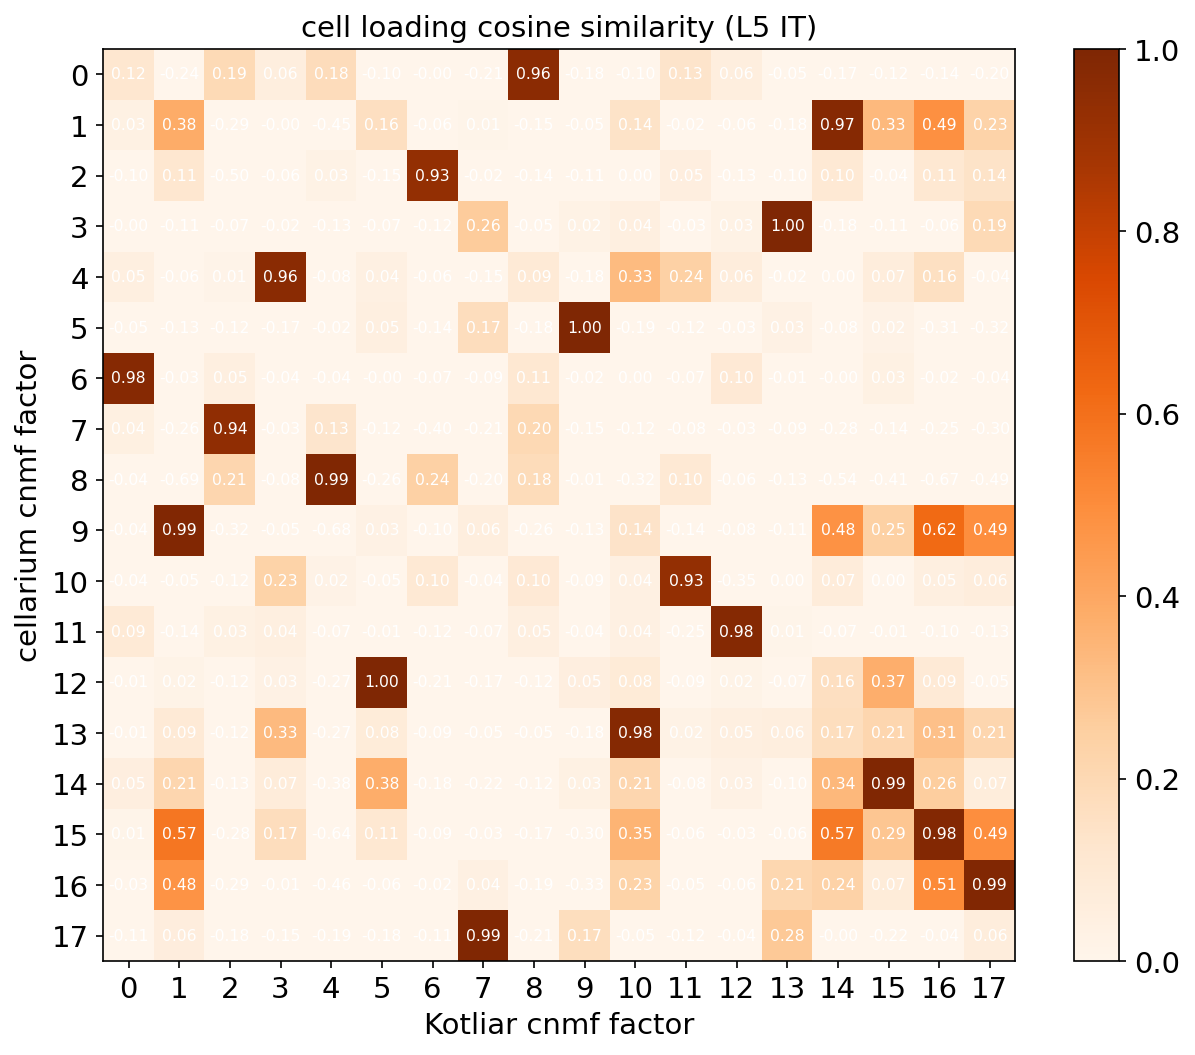

In [38]:
plt.figure(figsize=(10, 8))
plt.imshow(output.values, cmap='Oranges', vmin=0.0, vmax=1.0)
plt.colorbar()

# Print values on each pixel
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        plt.text(j, i, f'{output.values[i, j]:.2f}', 
                 ha='center', va='center', color='white', fontsize=7.5)
plt.grid(False)
plt.xticks(range(output.shape[1]))
plt.yticks(range(output.shape[0]))
plt.title('cell loading cosine similarity (L5 IT)')
plt.ylabel('cellarium cnmf factor') # cellarium cnmf factor
plt.xlabel('Kotliar cnmf factor') # ground truth factor
# plt.savefig('L5IT_cellarium_kotliar_cellfactor.png', dpi=300)
plt.show()

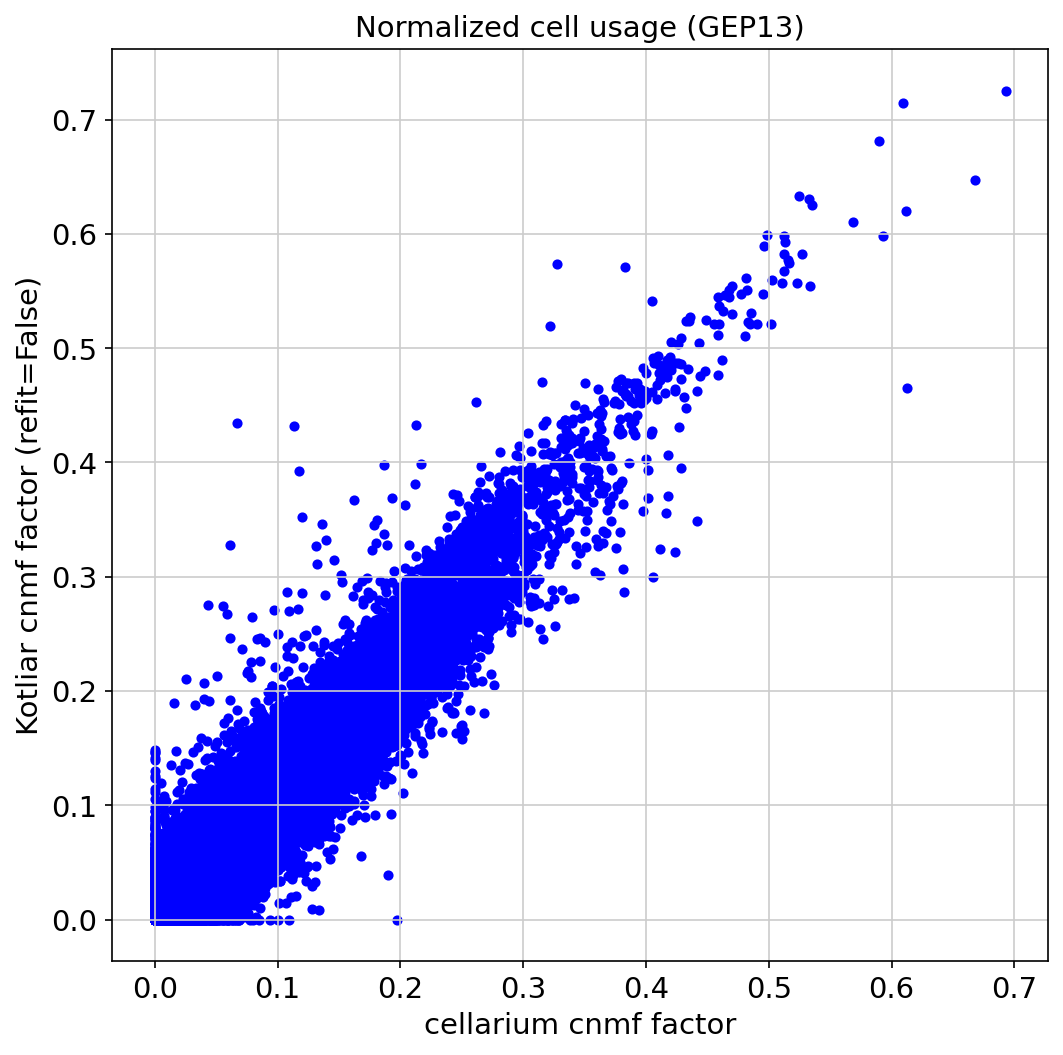

In [40]:
new_cnmf_index = 11
old_cnmf_index = 12

plt.figure(figsize=(8, 8))
# plt.scatter(full_D_kg[new_cnmf_index].values, gene_factor.values[:,old_cnmf_index], c ="blue")
plt.scatter(df.values[:, new_cnmf_index], cell_factor.values[:,old_cnmf_index], c ="blue", s=15)

plt.title('Normalized cell usage (GEP13)')
plt.xlabel('cellarium cnmf factor')
plt.ylabel('Kotliar cnmf factor (refit=False)')
# plt.savefig('L5IT_kotliar(refit=T)_comp_GEP13_cellusage.png', dpi=300) 
plt.show()